In [4]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from seisnet.dataloaders import random_dataloader
from seisnet.utils import get_data_dir

In [16]:
model = sbm.PhaseNet(phases="PSN", norm="peak")

if torch.cuda.is_available():
    model.cuda()
    print("Running on GPU")
else:
    print("Running on CPU")

Running on CPU


In [18]:
train_loader, dev_loader = random_dataloader(f"{get_data_dir()}/train_npz",sample_size=100, batch_size=20)

In [19]:
learning_rate = 1e-2
epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
    h = h.mean()  # Mean over batch axis
    return -h


train_loss = []
val_loss = []

def train_loop(dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss = 0
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_loss /= num_batches
    train_loss.append(epoch_loss)

    



def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    val_loss.append(test_loss)
    print(f"Test avg loss: {test_loss:>8f} \n")

In [20]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
loss: 0.937903  [    0/   75]
Test avg loss: 0.790637 

Epoch 2
-------------------------------
loss: 0.713625  [    0/   75]
Test avg loss: 0.696412 

Epoch 3
-------------------------------
loss: 0.561300  [    0/   75]
Test avg loss: 0.569454 

Epoch 4
-------------------------------
loss: 0.422595  [    0/   75]
Test avg loss: 0.543117 

Epoch 5
-------------------------------
loss: 0.323247  [    0/   75]
Test avg loss: 0.446341 

Epoch 6
-------------------------------
loss: 0.242210  [    0/   75]
Test avg loss: 0.350449 

Epoch 7
-------------------------------
loss: 0.181113  [    0/   75]
Test avg loss: 0.244159 

Epoch 8
-------------------------------
loss: 0.150212  [    0/   75]
Test avg loss: 0.166451 

Epoch 9
-------------------------------
loss: 0.113452  [    0/   75]
Test avg loss: 0.157492 

Epoch 10
-------------------------------
loss: 0.100868  [    0/   75]
Test avg loss: 0.132591 

Epoch 11
------------------------------

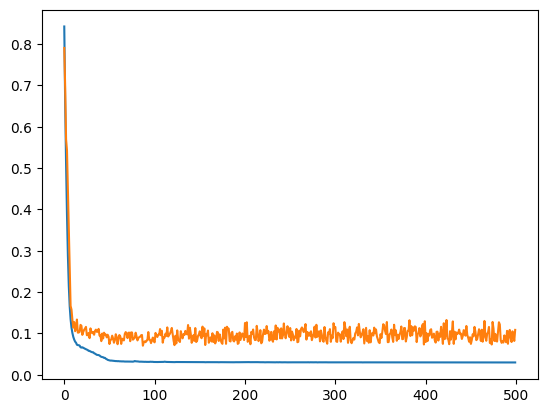

In [24]:
epch = np.arange(epochs)
plt.plot(epch,train_loss)
plt.plot(epch,val_loss)
# plt.yscale("log")